In [1]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import clear_output

import json

In [2]:
MODEL_FILE = "3.2. Esembler_RandomForest_Bureau.json"

In [3]:
# Random Forest
TREE_PARAMS = {
    "max_depth": 15,
    "min_samples_leaf": 17,
    "n_estimators": 500,
    "random_state": 0,
    "n_jobs": -1
}

In [4]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [5]:
# Check if Models exists

In [6]:
model_path = DATASET_DIR / "Models" / MODEL_FILE
MODEL_EXIST = model_path.is_file()

In [7]:
# Daten

In [8]:
app_train = pd.read_csv(DATASET_DIR / "4. FillNA" / "application.csv")
bureau = pd.read_csv(DATASET_DIR / "4. FillNA" / "bureau.csv")
app_train = app_train.set_index("SK_ID_CURR")
bureau = bureau.set_index("SK_ID_CURR")

In [9]:
bureau.head()

,CNT_BURAEU,B_Active,B_Closed,B_DAYS_CREDIT_ENDDATE,B_CREDIT_DAY_OVERDUE,B_AMT_CREDIT_SUM,B_AMT_CREDIT_SUM_DEBT,B_AMT_CREDIT_SUM_OVERDUE,B_AMT_ANNUITY
SK_ID_CURR,,,,,,,,,
100002,8.0,2.0,6.0,309.000000,0.000000,638235.000000,245781.000000,0.000000,0.000000
100003,4.0,1.0,3.0,1216.000000,0.000000,810000.000000,0.000000,0.000000,0.000000
100004,2.0,0.0,2.0,1172.145688,0.001403,792471.023437,353526.556281,0.001962,2735.621154
100007,1.0,0.0,1.0,1163.754146,0.001784,635755.340213,291016.898931,0.002387,2634.913696
100008,3.0,1.0,2.0,471.000000,0.000000,267606.000000,240057.000000,0.000000,0.000000


In [10]:
# Ermittlung Reihenfolge

In [11]:
y = app_train.loc[bureau.index]["TARGET"]
x = bureau

In [12]:
if not MODEL_EXIST:
    # unterteilt den trainingsdatensatz in trainings- und validierungsdatensätze
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)

    # logistisches Regressionsmodell
    model = RandomForestClassifier(**TREE_PARAMS)
    model.fit(x_train, y_train)

    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    print(auc)

    # Koeffizienten der einzelnen Klassen
    coef_dict = {}
    for coef, feat in zip(model.feature_importances_, x.columns.values):
        coef_dict[feat] = coef

    # Feature Importance
    d = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))
    order = list(d.keys())
    
    model_data = {
    "todo" : order,
    "keep" : [],
    "drop" : [],
    "params" : TREE_PARAMS,
    "auc" : [],
    "p" : [],
    "n" : []
    }
    
    auc_temp = 0.5

In [13]:
if MODEL_EXIST:
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'r') as file:
        model_data = json.load(file)
    auc_temp = model_data["auc"][-1]

In [14]:
#Entscheidungsbaum Parameterbestimmung

In [15]:
df = bureau

print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc_temp,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))
todo = model_data["todo"].copy()

for head in todo:
    
    model_data["keep"].append(head)
    
    X = df[model_data["keep"]]
    y = app_train.loc[bureau.index]["TARGET"]
    x = X
    
    model = RandomForestClassifier(**TREE_PARAMS).fit(x, y)
    
    aucs = []

    kfold = KFold(5, shuffle=True, random_state=1)

    for train, test in kfold.split(x):
        model.fit(x.iloc[train], y.iloc[train])
        auc = roc_auc_score(y.iloc[test], model.predict_proba(x.iloc[test])[:,1])
        aucs.append(auc)
    
    auc = np.mean(aucs)
    n = len(X)
    p = len(X.columns)
    
    if auc > auc_temp:
        
        model_data["auc"].append(auc)
        model_data["p"].append(p)
        model_data["n"].append(n)
        
        auc_temp = auc
        
    else:
        model_data["keep"].remove(head)
        model_data["drop"].append(head)
    
    model_data["todo"].remove(head)
    
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'w') as file:
        json.dump(model_data, file)
        
    clear_output(wait=True)
    print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))

auc: 0.6125, todo: 0, keep: 7, drop: 2


        auc  p       n
6  0.612539  7  263491


<AxesSubplot:>

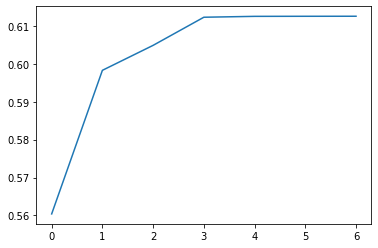

In [16]:
data = {
    "auc" : model_data["auc"],
    "p" : model_data["p"],
    "n" : model_data["n"]
}

result = pd.DataFrame(data)

print(result[result["auc"] == result["auc"].max()])
result["auc"].plot()

In [17]:
model_data["keep"]

['B_Active',
 'B_Closed',
 'B_AMT_CREDIT_SUM',
 'B_AMT_CREDIT_SUM_DEBT',
 'B_DAYS_CREDIT_ENDDATE',
 'B_AMT_CREDIT_SUM_OVERDUE',
 'B_AMT_ANNUITY']

In [18]:
model_data["drop"]

['B_CREDIT_DAY_OVERDUE', 'CNT_BURAEU']

In [19]:
model = RandomForestClassifier(**TREE_PARAMS)

TPRs = []
TNRs = []
Ps = []
NPVs = []
Fs = []
As = []
aucs = []

kfold = KFold(5, shuffle=True, random_state=1)

X = df[model_data["keep"]]
y = app_train.loc[bureau.index]["TARGET"]
x = X

for ID_TRAIN, ID_TEST in kfold.split(x):
    
    x_train = x.iloc[ID_TRAIN]
    y_train = y.iloc[ID_TRAIN]
    x_test = x.iloc[ID_TEST]
    y_test = y.iloc[ID_TEST]
    
    model.fit(x_train, y_train)
    (tn,fp),(fn,tp)=confusion_matrix(y_test, model.predict(x_test))
    
    # TPR
    TPR = R = tp/(tp+fn)
    # TNR
    TNR = tn/(tn+fp)
    # Precision
    P = tp/(tp+fp)
    # NPV
    NPV = tn/(tn+fn)
    # F-Score
    F = 2*P*R/(P+R)
    # Accuracy
    A = (tp+tn)/(tp+tn+fp+fn)
    # AUC
    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    
    TPRs.append(TPR)
    TNRs.append(TNR)
    Ps.append(P)
    NPVs.append(NPV)
    Fs.append(F)
    As.append(A)
    aucs.append(auc)
    
    print('TPR: %.4f' % TPR, 'TNR: %.4f' % TNR, 'P: %.4f' % P, 'NPV: %.4f' % NPV, 'F: %.4f' % F, 'Accuracy: %.4f' % A, 'AUC: %.4f' % auc)

print("\n")
print("Durchschnitte:")
print('TPR: %.4f' % np.mean(TPRs), 'TNR: %.4f' % np.mean(TNRs), 'P: %.4f' % np.mean(Ps), 'NPV: %.4f' % np.mean(NPVs), 'F: %.4f' % np.mean(Fs), 'Accuracy: %.4f' % np.mean(As), 'AUC: %.4f' % np.mean(aucs))

<ipython-input-19-acf5d4b5eae5>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9250 F: nan Accuracy: 0.9250 AUC: 0.6135


<ipython-input-19-acf5d4b5eae5>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9226 F: nan Accuracy: 0.9226 AUC: 0.6238


<ipython-input-19-acf5d4b5eae5>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9223 F: nan Accuracy: 0.9223 AUC: 0.6299


<ipython-input-19-acf5d4b5eae5>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9218 F: nan Accuracy: 0.9218 AUC: 0.6237


<ipython-input-19-acf5d4b5eae5>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9218 F: nan Accuracy: 0.9218 AUC: 0.6151


Durchschnitte:
TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9227 F: nan Accuracy: 0.9227 AUC: 0.6212
